In [2]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch import optim, nn
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Tahoma','DejaVu Sans',
                   'Lucida Grande','Verdana']
plt.rcParams['axes.unicode_minus'] = False

# Set GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

import torch
from torchvision import datasets, transforms
import os

# Path of the dataset
data_dir = "/content/drive/MyDrive/MTB/MTB" #The Google Drive link for the dataset is: https://drive.google.com/drive/folders/1GpjwQiQ5FjWnj4LXZ_ettApsOYwlIkqs?usp=sharing

# Size of the image
img_height = 100
img_width = 100

# Data preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset
full_dataset = datasets.ImageFolder(data_dir)

# Get the size of the dataset
full_size = len(full_dataset)
train_size = int(0.7 * full_size)  # Assuming the training set occupies 80%
val_size = full_size - train_size  # Size of the validation set

# Randomly split the dataset
torch.manual_seed(0)  # Set a random seed to ensure reproducibility of results
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Apply data augmentation to the training set
train_dataset.dataset.transform = data_transforms['train']

# Create a data loader
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

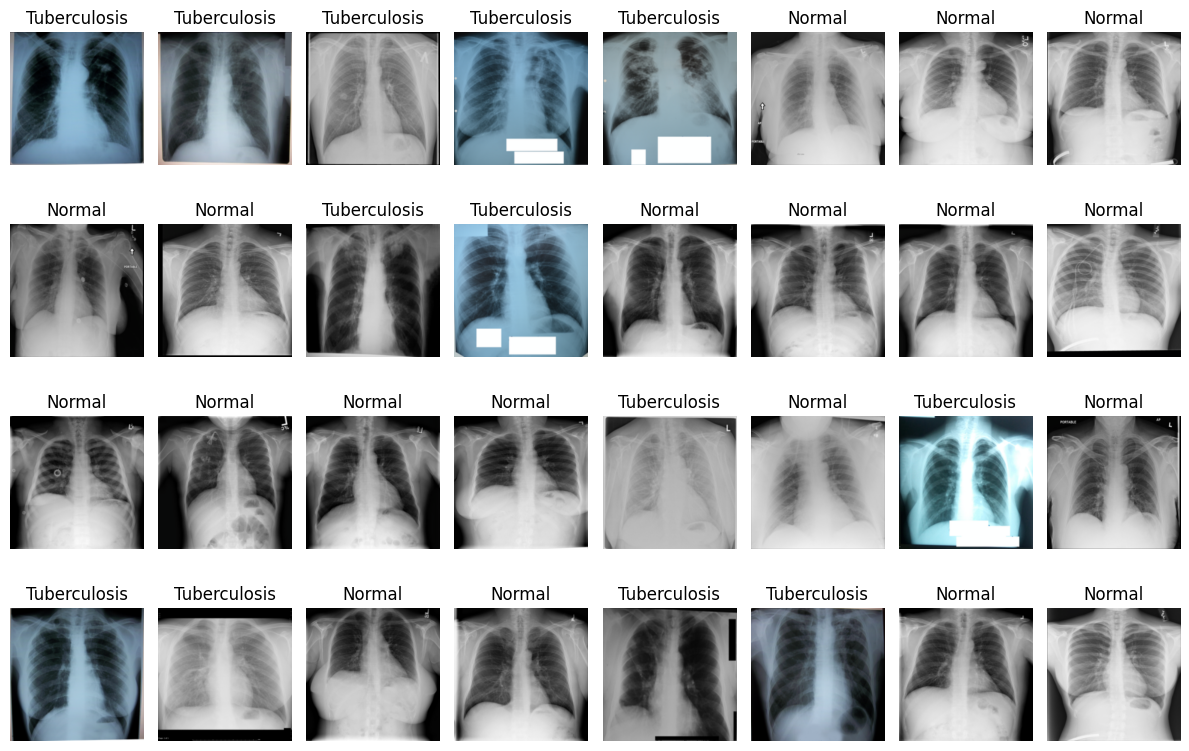

In [4]:
# Get a batch of training images
inputs, labels = next(iter(train_dataloader))

# Convert a tensor to a numpy array
inputs = inputs.numpy()
labels = labels.numpy()

# Get the names of category labels
label_names = [class_names[label] for label in labels]

# Display image and label
fig, axes = plt.subplots(figsize=(12, 8), nrows=4, ncols=8)
axes = axes.flatten()

for i, (image, label) in enumerate(zip(inputs, label_names)):
    image = np.transpose(image, (1, 2, 0))  # Adjust channel order
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # Reverse normalization
    image = np.clip(image, 0, 1)  # Clip pixel values to be between 0 and 1

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

In [5]:
!pip -q install timm
# using a pre-trained model
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_ftrs = model.head.in_features
# Modify the last layer according to the classification task
model.head = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# Print model summary
print(model)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.6 MB/s eta 0:00:00


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
!pip -q install vit_pytorch linformer
from linformer import Linformer
from vit_pytorch.efficient import ViT
from torch.optim.lr_scheduler import StepLR

# without using a pre-trained model
in_features=128
efficient_transformer = Linformer(
    dim=in_features,
    seq_len=49+1,
    depth=12,
    heads=8,
    k=64
)

model = ViT(
    dim=in_features,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
)
num_ftrs = in_features

# Modify the last layer according to the classification task
model.head = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# Print model summary
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe

In [8]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Begin training the model
num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# Initialize the logger
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterating through the data
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # Perform forward propagation
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Only perform backpropagation and optimization in training mode
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Calculate the statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

        # Record the loss and accuracy for each epoch
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0/9
----------
train Loss: 0.0400 Acc: 0.9946
val Loss: 0.0277 Acc: 0.9938

Epoch 1/9
----------
train Loss: 0.0019 Acc: 1.0000
val Loss: 0.0845 Acc: 0.9896

Epoch 2/9
----------
train Loss: 0.0003 Acc: 1.0000
val Loss: 0.1814 Acc: 0.9771

Epoch 3/9
----------
train Loss: 0.0341 Acc: 0.9893
val Loss: 0.0337 Acc: 0.9896

Epoch 4/9
----------
train Loss: 0.0020 Acc: 1.0000
val Loss: 0.0344 Acc: 0.9938

Epoch 5/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0285 Acc: 0.9938

Epoch 6/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0287 Acc: 0.9938

Epoch 7/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0289 Acc: 0.9938

Epoch 8/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0293 Acc: 0.9938

Epoch 9/9
----------
train Loss: 0.0000 Acc: 1.0000
val Loss: 0.0294 Acc: 0.9938

Best val Acc: 0.993750


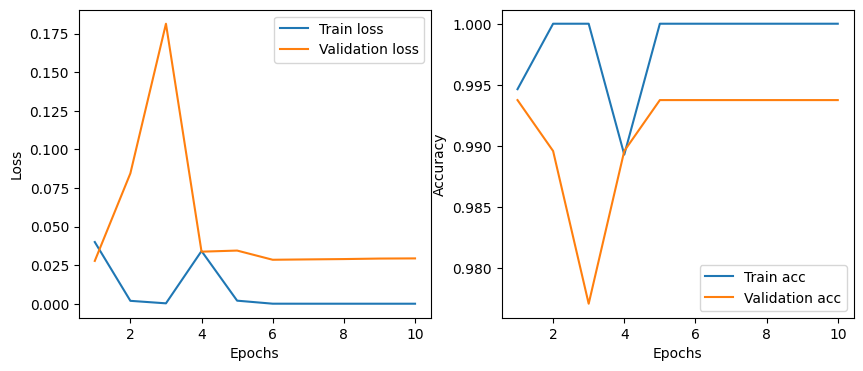

In [12]:
epoch = range(1, len(train_loss_history)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(epoch, train_loss_history, label='Train loss')
ax[0].plot(epoch, val_loss_history, label='Validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epoch, train_acc_history, label='Train acc')
ax[1].plot(epoch, val_acc_history, label='Validation acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

#plt.savefig("loss-acc.pdf", dpi=300,format="pdf")

The sensitivity of the validation set is: 0.9898477157360406 
 The specificity of the validation set is: 0.9964664310954063 
 The accuracy of the validation set is: 0.99375 
 The error rate of the validation set is: 0.006249999999999978 
 The precision of the validation set is: 0.9948979591836735 
 The F1 score of the validation set is: 0.9923664122137404 
 The Matthews correlation coefficient (MCC) of the validation set is: 0.9870846253098727
The sensitivity of the train set is: 0.9898477157360406 
 The specificity of the train set is: 0.9964664310954063 
 The accuracy of the train set is: 0.99375 
 The error rate of the train set is: 0.006249999999999978 
 The precision of the train set is: 0.9948979591836735 
 The F1 score of the train set is: 0.9923664122137404 
 The Matthews correlation coefficient (MCC) of the train set is: 0.9870846253098727


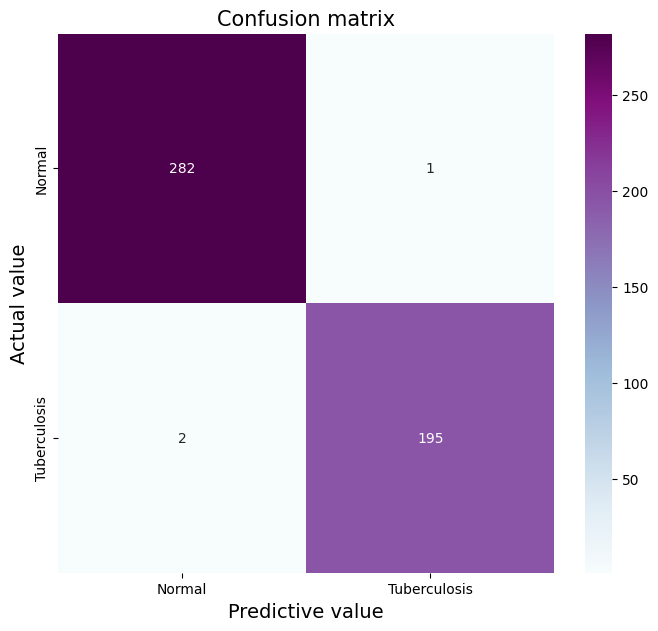

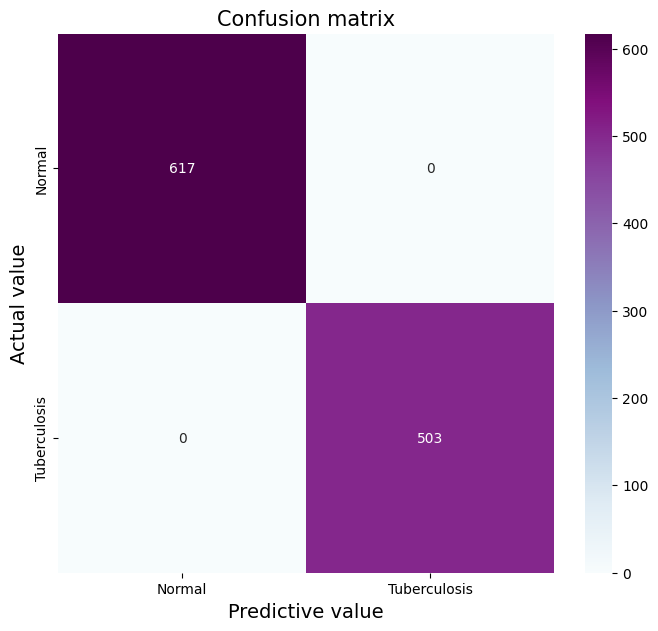

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import imshow

# Define a function to plot a confusion matrix
def plot_cm(labels, predictions):

    # Generate a confusion matrix.
    conf_numpy = confusion_matrix(labels, predictions)
    # Convert the matrix into a DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)

    plt.figure(figsize=(8,7))

    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")

    plt.title('Confusion matrix',fontsize=15)
    plt.ylabel('Actual value',fontsize=14)
    plt.xlabel('Predictive value',fontsize=14)

def evaluate_model(model, dataloader, device):
    model.eval()   # Set the model to evaluation mode
    true_labels = []
    pred_labels = []
    # Traverse the data
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

# Get the predicted and true labels.
true_labels, pred_labels = evaluate_model(model, dataloaders['val'], device)

# Compute the confusion matrix.
cm_val = confusion_matrix(true_labels, pred_labels)
a_val = cm_val[0,0]
b_val = cm_val[0,1]
c_val = cm_val[1,0]
d_val = cm_val[1,1]

# Calculate various performance metrics.
acc_val = (a_val+d_val)/(a_val+b_val+c_val+d_val)  # Accuracy
error_rate_val = 1 - acc_val  # Error rate
sen_val = d_val/(d_val+c_val)  # Sensitivity
sep_val = a_val/(a_val+b_val)  # Specificity
precision_val = d_val/(b_val+d_val)  # Precision
F1_val = (2*precision_val*sen_val)/(precision_val+sen_val)  # F1 score
MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val)))  # Matthews correlation coefficient

# Print out performance metrics
print("The sensitivity of the validation set is:", sen_val,
      "\n The specificity of the validation set is:", sep_val,
      "\n The accuracy of the validation set is:", acc_val,
      "\n The error rate of the validation set is:", error_rate_val,
      "\n The precision of the validation set is:", precision_val,
      "\n The F1 score of the validation set is:", F1_val,
      "\n The Matthews correlation coefficient (MCC) of the validation set is:", MCC_val)
# Plot confusion matrix
plot_cm(true_labels, pred_labels)


# Get predicted and true labels
train_true_labels, train_pred_labels = evaluate_model(model, dataloaders['train'], device)
# Calculate the confusion matrix
cm_train = confusion_matrix(train_true_labels, train_pred_labels)
a_train = cm_train[0,0]
b_train = cm_train[0,1]
c_train = cm_train[1,0]
d_train = cm_train[1,1]
acc_train = (a_train+d_train)/(a_train+b_train+c_train+d_train)
error_rate_train = 1 - acc_train
sen_train = d_train/(d_train+c_train)
sep_train = a_train/(a_train+b_train)
precision_train = d_train/(b_train+d_train)
F1_train = (2*precision_train*sen_train)/(precision_train+sen_train)
MCC_train = (d_train*a_train-b_train*c_train) / (math.sqrt((d_train+b_train)*(d_train+c_train)*(a_train+b_train)*(a_train+c_train)))
print("The sensitivity of the train set is:", sen_val,
      "\n The specificity of the train set is:", sep_val,
      "\n The accuracy of the train set is:", acc_val,
      "\n The error rate of the train set is:", error_rate_val,
      "\n The precision of the train set is:", precision_val,
      "\n The F1 score of the train set is:", F1_val,
      "\n The Matthews correlation coefficient (MCC) of the train set is:", MCC_val)

# Plot confusion matrix
plot_cm(train_true_labels, train_pred_labels)

The AUC value for the training set is: 1.0 The AUC value for the validation set is: 0.9998206310200713


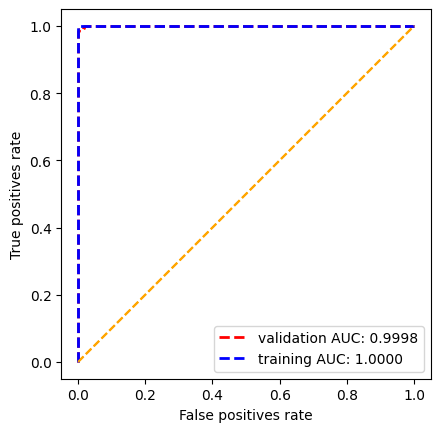

In [14]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import math

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    ax = plt.gca()
    ax.set_aspect('equal')


# Ensure that the model is in evaluation mode.
model.eval()

train_ds = dataloaders['train']
val_ds = dataloaders['val']

val_pre_auc   = []
val_label_auc = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = image.unsqueeze(0).to(device)  # Add an additional dimension in the 0th dimension and move the image to the appropriate device.
        prediction_auc = model(img_array)  # Make predictions using the model
        val_pre_auc.append(prediction_auc.detach().cpu().numpy()[:,1])
        val_label_auc.append(label.item())  # Use Tensor.item() to get the value of the Tensor.
auc_score_val = metrics.roc_auc_score(val_label_auc, val_pre_auc)


train_pre_auc   = []
train_label_auc = []

for images, labels in train_ds:
    for image, label in zip(images, labels):
        img_array_train = image.unsqueeze(0).to(device)
        prediction_auc = model(img_array_train)
        train_pre_auc.append(prediction_auc.detach().cpu().numpy()[:,1])  # Output the probabilities instead of labels!
        train_label_auc.append(label.item())
auc_score_train = metrics.roc_auc_score(train_label_auc, train_pre_auc)

plot_roc('validation AUC: {0:.4f}'.format(auc_score_val), val_label_auc , val_pre_auc , color="red", linestyle='--')
plot_roc('training AUC: {0:.4f}'.format(auc_score_train), train_label_auc, train_pre_auc, color="blue", linestyle='--')
plt.legend(loc='lower right')
#plt.savefig("roc.pdf", dpi=300,format="pdf")

print("The AUC value for the training set is:",auc_score_train, "The AUC value for the validation set is:",auc_score_val)

In [15]:
torch.save(model, '/content/drive/MyDrive/9998model.pt')